In [7]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
import shap
import seaborn as sns
import matplotlib.pyplot as plt

# Load the pre-trained model
model_path = "C:/Users/Kuldeep/OneDrive/Desktop/TechMeet/NeuralNet/NeuralNet/final_model.keras"
model = load_model(model_path)

# Example Usage
team1 = ["RD Gaikwad", "DP Conway", "RV Uthappa", "AT Rayudu", "RA Jadeja", "S Dube", "MS Dhoni", "DJ Bravo", "MJ Santner", "AF Milne", "TU Deshpande"]
team2 = ["AM Rahane", "VR Iyer", "N Rana", "SS Iyer", "SW Billings", "SP Jackson", "AD Russell", "SP Narine", "UT Yadav", "Shivam Mavi", "CV Varun"]
date = '2022-03-26'  # Replace with the match date

def compute_rolling_averages(df, player_name, date, column, windows):
    player_data = df[(df['player_name'] == player_name) & (df['date'] < date)].sort_values(by='date')
    averages = []
    for window in windows:
        avg = player_data[column].tail(window).mean()
        averages.append(avg if not np.isnan(avg) else 0)
    overall_avg = player_data[column].mean()
    averages.append(overall_avg if not np.isnan(overall_avg) else 0)
    return averages

def get_player_features(player_name, date, data_folder, windows):
    player_file = os.path.join(data_folder, f"{player_name}.csv")
    if not os.path.exists(player_file):
        raise FileNotFoundError(f"Data file for player {player_name} not found.")
    
    player_data = pd.read_csv(player_file)
    batting_avgs = compute_rolling_averages(player_data, player_name, date, 'batting_points', windows)
    bowling_avgs = compute_rolling_averages(player_data, player_name, date, 'bowling_points', windows)
    fielding_avgs = compute_rolling_averages(player_data, player_name, date, 'fielding_points', windows)
    
    return batting_avgs + bowling_avgs + fielding_avgs

def get_team_features(team_players, opponent_players, date, data_folder, windows):
    team_features = []
    opponent_features = []
    
    for opponent_name in opponent_players:
        opponent_file = os.path.join(data_folder, f"{opponent_name}.csv")
        if not os.path.exists(opponent_file):
            raise FileNotFoundError(f"Data file for opponent player {opponent_name} not found.")
        
        opponent_data = pd.read_csv(opponent_file)
        opponent_batting_avgs = compute_rolling_averages(opponent_data, opponent_name, date, 'batting_points', windows)
        opponent_bowling_avgs = compute_rolling_averages(opponent_data, opponent_name, date, 'bowling_points', windows)
        opponent_fielding_avgs = compute_rolling_averages(opponent_data, opponent_name, date, 'fielding_points', windows)
        
        opponent_features += opponent_batting_avgs + opponent_bowling_avgs + opponent_fielding_avgs
    
    for player_name in team_players:
        player_features = get_player_features(player_name, date, data_folder, windows)
        full_features = player_features + opponent_features
        team_features.append((player_name, full_features))
    
    return team_features

def select_top_11_players_with_shap(team1, team2, date, model, data_folder, windows):
    team1_features = get_team_features(team1, team2, date, data_folder, windows)
    team2_features = get_team_features(team2, team1, date, data_folder, windows)
    
    all_players = team1_features + team2_features
    player_names = [player[0] for player in all_players]
    feature_matrix = np.array([player[1] for player in all_players])
    
    # Predict total fantasy points (sum of all categories)
    predictions = model.predict(feature_matrix)
    total_fantasy_points = predictions.sum(axis=1)
    
    player_scores = [
        (player_names[i], total_fantasy_points[i])
        for i in range(len(player_names))
    ]
    
    sorted_players = sorted(player_scores, key=lambda x: x[1], reverse=True)
    top_11_players = sorted_players[:11]
    
    # Calculate SHAP values for total fantasy points
    shap_values = calculate_shap_values(model, feature_matrix)
    
    return top_11_players, shap_values, player_names, feature_matrix

def calculate_shap_values(model, feature_matrix):
    explainer = shap.KernelExplainer(model.predict, feature_matrix)
    shap_values = explainer.shap_values(feature_matrix)
    return shap_values

def fetch_actual_points(players, date, data_folder):
    actual_points = []
    
    for player_name in players:
        player_file = os.path.join(data_folder, f"{player_name}.csv")
        if not os.path.exists(player_file):
            raise FileNotFoundError(f"Data file for player {player_name} not found.")
        
        player_data = pd.read_csv(player_file)
        player_row = player_data[player_data['date'] == date]
        if player_row.empty:
            print(f"No data found for player {player_name} on date {date}. Assigning 0 points.")
            batting_points = bowling_points = fielding_points = total_points = 0
        else:
            batting_points = player_row.iloc[0]['batting_points']
            bowling_points = player_row.iloc[0]['bowling_points']
            fielding_points = player_row.iloc[0]['fielding_points']
            total_points = batting_points + bowling_points + fielding_points
        
        # Append to the list
        actual_points.append((player_name, batting_points, bowling_points, fielding_points, total_points))
    
    return actual_points

# Example usage:
top_11_players, shap_values, player_names, feature_matrix = select_top_11_players_with_shap(
    team1, team2, date, model, data_folder='player_csv', windows=[3, 5, 10, 20]
)

# Display the results for top 11 players
print("Top 11 Players Based on Predicted Fantasy Points:")
print(f"{'Player':<15} {'Total Points':<15}")
print("-" * 30)
for player, total in top_11_players:
    print(f"{player:<15} {total:<15.2f}")

# SHAP values are for the total fantasy points, and feature matrix shape should match (22, 180)
print(f"Shape of SHAP values: {np.shape(shap_values)}")
print(f"Shape of feature matrix: {feature_matrix.shape}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


  0%|          | 0/22 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


  5%|▍         | 1/22 [00:07<02:38,  7.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


  9%|▉         | 2/22 [00:14<02:25,  7.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


 14%|█▎        | 3/22 [00:21<02:12,  6.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


 18%|█▊        | 4/22 [00:28<02:05,  6.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


 23%|██▎       | 5/22 [00:35<01:58,  6.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


 27%|██▋       | 6/22 [00:42<01:55,  7.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


 32%|███▏      | 7/22 [00:52<01:58,  7.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


 36%|███▋      | 8/22 [01:00<01:50,  7.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


 41%|████      | 9/22 [01:08<01:42,  7.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


 45%|████▌     | 10/22 [01:15<01:33,  7.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


 50%|█████     | 11/22 [01:22<01:23,  7.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


 55%|█████▍    | 12/22 [01:30<01:17,  7.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


 59%|█████▉    | 13/22 [01:38<01:09,  7.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


 64%|██████▎   | 14/22 [01:46<01:03,  7.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


 68%|██████▊   | 15/22 [01:52<00:50,  7.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


 73%|███████▎  | 16/22 [01:57<00:39,  6.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


 77%|███████▋  | 17/22 [02:03<00:31,  6.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


 82%|████████▏ | 18/22 [02:08<00:24,  6.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


 86%|████████▋ | 19/22 [02:14<00:17,  5.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


 91%|█████████ | 20/22 [02:19<00:11,  5.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


 95%|█████████▌| 21/22 [02:24<00:05,  5.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


100%|██████████| 22/22 [02:30<00:00,  6.83s/it]

Top 11 Players Based on Predicted Fantasy Points:
Player          Total Points   
------------------------------
RD Gaikwad      28.79          
VR Iyer         27.78          
DJ Bravo        25.13          
SP Narine       24.18          
Shivam Mavi     23.63          
AF Milne        23.04          
CV Varun        22.54          
MJ Santner      21.88          
RV Uthappa      20.39          
RA Jadeja       18.54          
SS Iyer         18.38          
Shape of SHAP values: (22, 180, 3)
Shape of feature matrix: (22, 180)


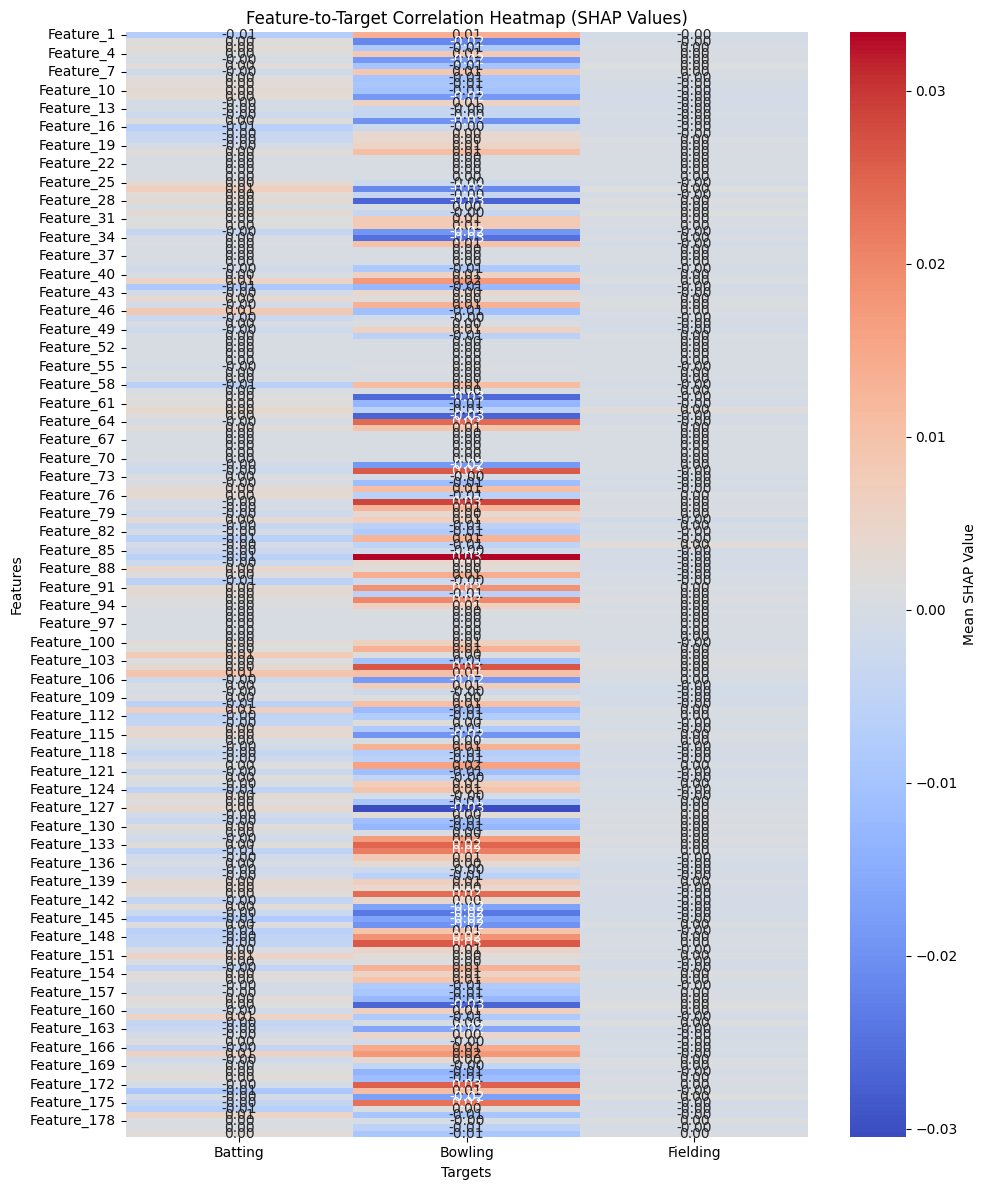

In [8]:
def plot_shap_correlations(shap_values, feature_names, target_labels):
    """
    Plots the feature-to-target correlation heatmap for SHAP values.

    Parameters:
    shap_values_combined (np.ndarray): Combined SHAP values with shape (22, 180, 3).
    feature_names (list): List of feature names corresponding to the 180 features.
    target_labels (list): Labels for the targets, e.g., ['Batting', 'Bowling', 'Fielding'].
    """
    # Compute mean SHAP values for each feature and target
    mean_shap_values = shap_values.mean(axis=0)  # Shape: (180, 3)

    # Create a DataFrame for easier handling
    correlation_df = pd.DataFrame(mean_shap_values, columns=target_labels, index=feature_names)

    # Plot the heatmap
    plt.figure(figsize=(10, 12))
    sns.heatmap(correlation_df, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={"label": "Mean SHAP Value"})
    plt.title("Feature-to-Target Correlation Heatmap (SHAP Values)")
    plt.xlabel("Targets")
    plt.ylabel("Features")
    plt.tight_layout()
    plt.show()

# Example feature names and target labels
feature_names = [f"Feature_{i+1}" for i in range(180)]
target_labels = ["Batting", "Bowling", "Fielding"]

# Assuming `shap_values_combined` has shape (22, 180, 3)
plot_shap_correlations(shap_values, feature_names, target_labels)

In [10]:
import numpy as np 
print(f"SHAP values shape: {np.shape(shap_values)}")
# print(shap_values_combined.shape)

SHAP values shape: (22, 180, 3)


In [11]:
shap_values[:,:,1].shape
# feature_matrix.shape

(22, 180)

Generating SHAP summary plot for Batting...


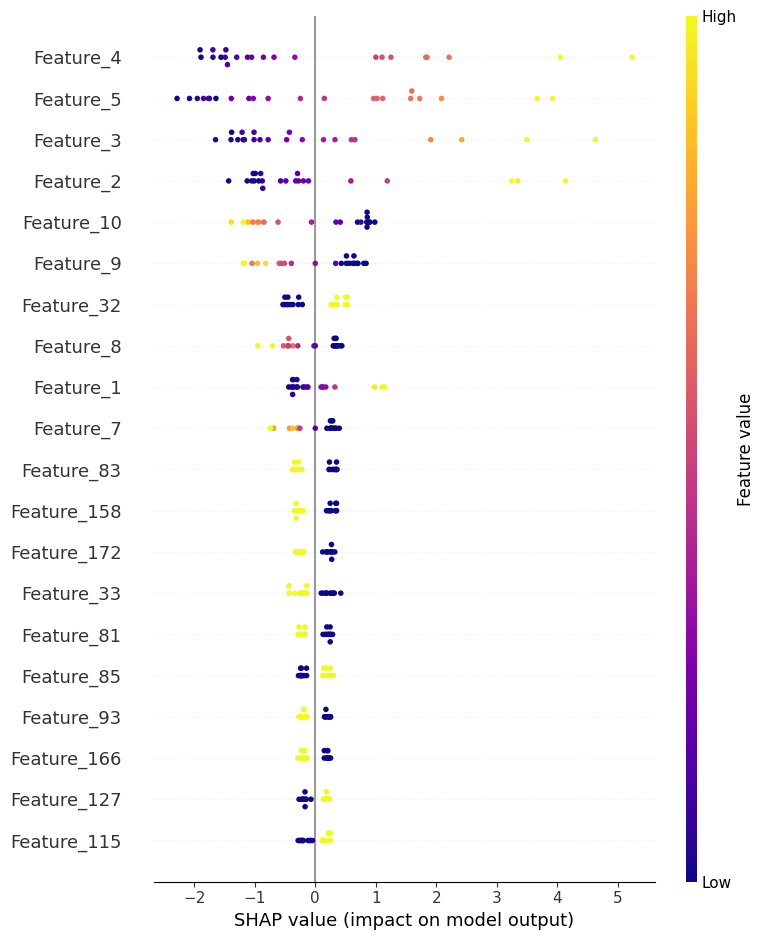

Generating SHAP summary plot for Bowling...


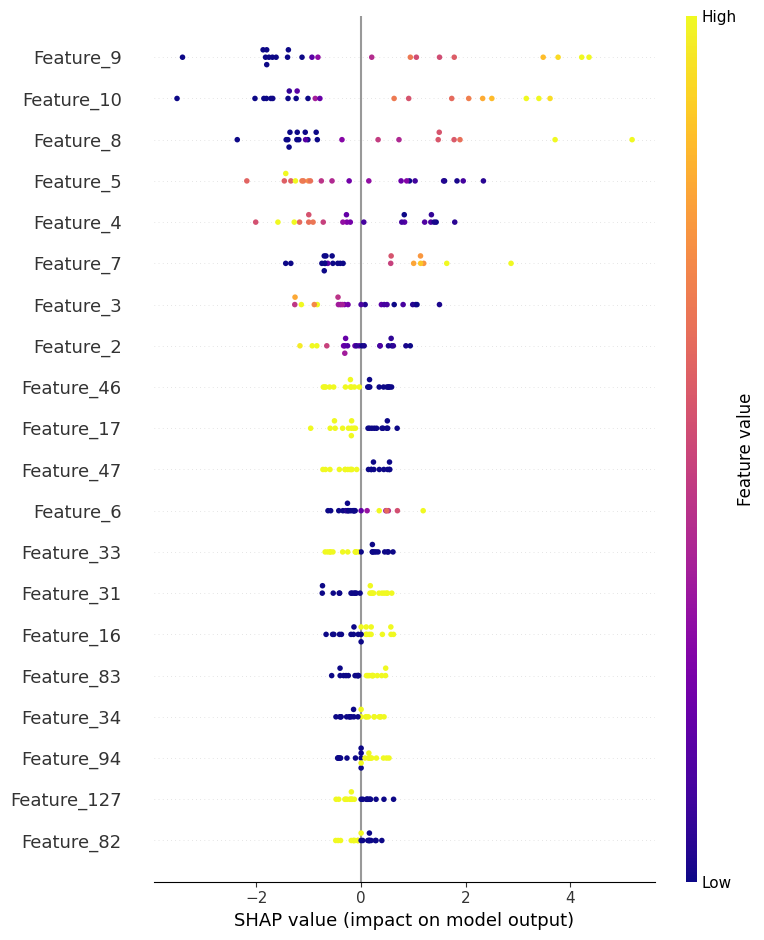

Generating SHAP summary plot for Fielding...


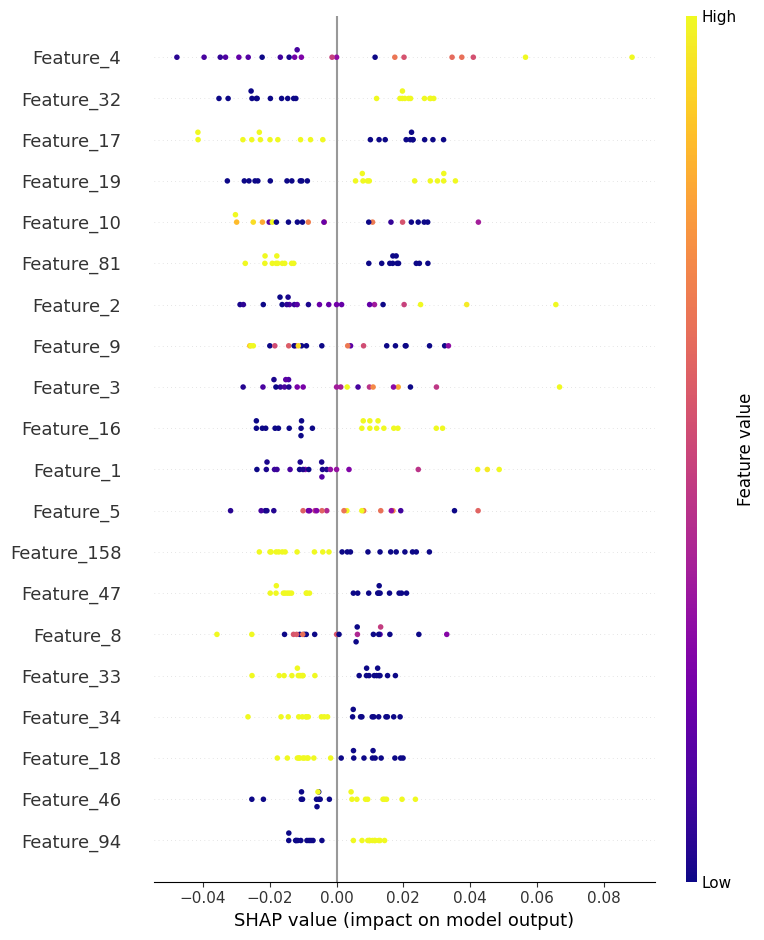

In [13]:
import shap

def plot_shap_summary_with_color_intensity(shap_values_combined, feature_names, feature_values, target_labels):
    """
    Plots SHAP summary plots for batting, bowling, and fielding SHAP values, with color intensity
    indicating the high and low feature values and their impact on the model output.

    Parameters:
    shap_values_combined (np.ndarray): Combined SHAP values with shape (22, 180, 3).
    feature_names (list): List of feature names corresponding to the 180 features.
    feature_values (np.ndarray): Array of feature values (shape: 22, 180) corresponding to the SHAP values.
    target_labels (list): Labels for the targets, e.g., ['Batting', 'Bowling', 'Fielding'].
    """
    for i, target_label in enumerate(target_labels):
        print(f"Generating SHAP summary plot for {target_label}...")
        
        # Extract SHAP values and corresponding feature values for the current target
        shap_values_target = shap_values[:, :, i]
        feature_values_target = feature_matrix[:, :]  # All features for current target
        
        # Generate the SHAP summary plot with color intensity
        shap.summary_plot(
            shap_values_target, 
            features=feature_values_target, 
            feature_names=feature_names, 
            plot_type="dot", 
            cmap="plasma",  # Color map for feature impact
            show=True,         # Display the plot
            title=f"SHAP Summary Plot for {target_label}"
        )
            
plot_shap_summary_with_color_intensity(shap_values, feature_names, feature_matrix, target_labels)

# Example usage (assuming you have a feature_values array with shape [22, 180]):
# `shap_values_combined`: SHAP values for each target (batting, bowling, fielding)
# `feature_values`: Actual values for the features used for plotting



In [94]:
import numpy as np
import pandas as pd

def extract_top_n_impacting_features_per_player(shap_values, feature_names, top_n=10):
    """
    Extracts the top N high-impact features for each player based on their SHAP values.
    
    Parameters:
    shap_values (np.ndarray): SHAP values for each target (shape: [n_players, n_features, n_targets]).
    feature_names (list): List of feature names corresponding to the n_features.
    top_n (int): Number of top features to select for each player based on the highest absolute SHAP value.
    
    Returns:
    pd.DataFrame: DataFrame containing top N high-impact features for each player with their SHAP values.
    """
    n_players, n_features, n_targets = shap_values.shape
    top_features_data = []

    # Loop through each player
    for player_idx in range(n_players):
        player_shap_values = np.abs(shap_values[player_idx])  # Absolute SHAP values for current player
        
        # Get the top N features for each player across all targets
        mean_shap_values_for_player = np.mean(player_shap_values, axis=1)  # Mean across all targets
        
        # Get indices of the top N features based on their mean SHAP value
        top_n_indices = np.argsort(mean_shap_values_for_player)[-top_n:]
        
        # Gather the top N feature names and their corresponding SHAP values
        top_n_features = [feature_names[i] for i in top_n_indices]
        top_n_shap_values = mean_shap_values_for_player[top_n_indices]
        
        # Collect data for the current player
        player_data = {'Player': f'Player_{player_idx + 1}'}
        player_data.update({f'Top_Feature_{i+1}': top_n_features[i] for i in range(top_n)})
        player_data.update({f'Top_SHAP_{i+1}': top_n_shap_values[i] for i in range(top_n)})
        
        top_features_data.append(player_data)
    
    # Convert the collected data into a DataFrame
    top_features_df = pd.DataFrame(top_features_data)
    
    return top_features_df

# Example usage:
# `shap_values`: SHAP values for each target (batting, bowling, fielding), shape: [22, 180, 3]
# `feature_names`: List of feature names corresponding to the n_features

shap_values = np.random.rand(22, 180, 3)  # Example, replace with actual SHAP values
feature_names = [f"Feature_{i+1}" for i in range(180)]  # Adjust as per your actual feature names

# Extract top 10 high-impact features for each player
top_n_features_df = extract_top_n_impacting_features_per_player(shap_values, feature_names, top_n=10)

# Display the top N high-impact features for each player
print(top_n_features_df)


       Player Top_Feature_1 Top_Feature_2 Top_Feature_3 Top_Feature_4  \
0    Player_1    Feature_67    Feature_49    Feature_88   Feature_118   
1    Player_2   Feature_113    Feature_89   Feature_173   Feature_141   
2    Player_3   Feature_157    Feature_13    Feature_59     Feature_7   
3    Player_4   Feature_132   Feature_131    Feature_12    Feature_86   
4    Player_5    Feature_43   Feature_110    Feature_51   Feature_173   
5    Player_6   Feature_114   Feature_166    Feature_51    Feature_32   
6    Player_7   Feature_105   Feature_113   Feature_114   Feature_150   
7    Player_8    Feature_45    Feature_86   Feature_127    Feature_10   
8    Player_9    Feature_89   Feature_139   Feature_135   Feature_173   
9   Player_10   Feature_114   Feature_104    Feature_24    Feature_14   
10  Player_11    Feature_13    Feature_46    Feature_95    Feature_20   
11  Player_12    Feature_87    Feature_25    Feature_81    Feature_24   
12  Player_13    Feature_55   Feature_119    Featur

In [98]:
import numpy as np
import pandas as pd

def extract_top_10_impacting_features_per_player_with_sign(shap_values, feature_names):
    """
    Extracts the top 10 high-impact features for each player based on their SHAP values, 
    considering both positive and negative impacts and formats the output as specified.
    
    Parameters:
    shap_values (np.ndarray): SHAP values for each target (shape: [n_players, n_features, n_targets]).
    feature_names (list): List of feature names corresponding to the n_features.
    
    Returns:
    str: Formatted string showing the top 10 high-impact features for each player with their SHAP values.
    """
    n_players, n_features, n_targets = shap_values.shape
    output = []

    # Loop through each player
    for player_idx in range(n_players):
        player_shap_values = shap_values[player_idx]  # SHAP values for the current player (shape: [n_features, n_targets])
        
        # Get the mean SHAP value for each feature across all targets
        mean_shap_values_for_player = np.mean(player_shap_values, axis=1)  # Mean across all targets for each feature
        
        # Get the top 10 features by sorting based on the absolute value of the mean SHAP values
        top_10_indices = np.argsort(np.abs(mean_shap_values_for_player))[-10:]
        
        # Prepare the features and SHAP values (considering their sign)
        top_10_features = [feature_names[i] for i in top_10_indices]
        top_10_shap_values = mean_shap_values_for_player[top_10_indices]
        
        # Format the output for each player
        player_output = f"Player_{player_idx + 1} --> "
        feature_output = []
        
        for i in range(10):
            feature_name = top_10_features[i]
            shap_value = top_10_shap_values[i]
            sign = "+" if shap_value >= 0 else "-"
            feature_output.append(f"{feature_name}({sign}{abs(shap_value):.4f})")
        
        player_output += ", ".join(feature_output)
        output.append(player_output)
    
    return "\n".join(output)

# Example usage:
shap_values = np.random.randn(22, 180, 3)  # Example SHAP values for 22 players, 180 features, and 3 targets (random values)
feature_names = [f"Feature_{i+1}" for i in range(180)]  # List of feature names

# Extract top 10 high-impact features for each player considering both positive and negative impacts
top_10_features_output = extract_top_10_impacting_features_per_player_with_sign(shap_values, feature_names)

# Display the formatted output for the top 10 high-impact features for each player
print(top_10_features_output)


Player_1 --> Feature_34(+0.9784), Feature_108(-1.0142), Feature_174(-1.0259), Feature_152(-1.0376), Feature_114(-1.0941), Feature_179(+1.1142), Feature_156(-1.1909), Feature_121(+1.1946), Feature_45(+1.2310), Feature_58(+1.3316)
Player_2 --> Feature_171(+1.1672), Feature_132(-1.2038), Feature_148(+1.2041), Feature_59(+1.2790), Feature_174(-1.3314), Feature_162(-1.3797), Feature_81(+1.4123), Feature_94(+1.5180), Feature_61(+1.7035), Feature_49(-1.7418)
Player_3 --> Feature_154(-1.0745), Feature_104(-1.0792), Feature_169(+1.0978), Feature_64(+1.1314), Feature_28(-1.1807), Feature_23(-1.3315), Feature_71(+1.3368), Feature_75(+1.4890), Feature_155(-1.5986), Feature_76(-1.6803)
Player_4 --> Feature_21(-1.1314), Feature_24(-1.1467), Feature_164(-1.1472), Feature_3(-1.1811), Feature_118(+1.2291), Feature_150(-1.2954), Feature_170(-1.3312), Feature_48(-1.3905), Feature_136(-1.4122), Feature_57(+1.8274)
Player_5 --> Feature_148(+1.0503), Feature_41(+1.0594), Feature_77(-1.1296), Feature_43(+1.1

In [99]:
import numpy as np

def compute_overall_shap_value_range(shap_values):
    """
    Computes the overall range (min and max) of SHAP values across all features, players, and targets.
    
    Parameters:
    shap_values (np.ndarray): SHAP values with shape (n_players, n_features, n_targets).
    
    Returns:
    tuple: (min_shap_value, max_shap_value) representing the overall range of SHAP values.
    """
    # Find the minimum and maximum SHAP values across all dimensions (players, features, and targets)
    min_shap_value = np.min(shap_values)
    max_shap_value = np.max(shap_values)
    
    return min_shap_value, max_shap_value

# Example usage:
shap_values = np.random.randn(22, 180, 3)  # Example SHAP values for 22 players, 180 features, and 3 targets (random values)

# Compute the overall SHAP value range
min_shap, max_shap = compute_overall_shap_value_range(shap_values)

# Display the overall SHAP value range
print(f"Overall SHAP Value Range: Min = {min_shap}, Max = {max_shap}")


Overall SHAP Value Range: Min = -3.8486024567651533, Max = 4.386103448161889


In [46]:
shap_values_combined.shape
# # Example data shapes
# print(mean_shap_values.shape)  # Should print (180, 3)
# print(len(feature_names))      # Should print 180
# print(len(target_labels))      # Should print 3

(180, 3, 3)